**Блокнот по проведению word-level probing экспериментов**

In [1]:
import pandas as pd
# from google.colab import auth
# auth.authenticate_user()
# import gspread
# from oauth2client.client import GoogleCredentials

# # setup
# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from google.auth import default
# creds, _ = default()

# from google.colab import userdata
# signal_spreadsheet = userdata.get('SIGNAL_SPREADSHEET')

# gc = gspread.authorize(creds)
# # read data and put it in a dataframe
# gsheets = gc.open_by_url(signal_spreadsheet)
# sheets = gsheets.worksheet('FINAL').get_all_values()
df = pd.read_excel('stimuli_AZh.xlsx', sheet_name = 'FINAL')
# df = pd.DataFrame(sheets[1:], columns=sheets[0])
df["sentence_id"] = df.sentence_id.astype(int)

In [2]:
%pip install -q transformers sentencepiece conllu numpy pandas scikit-learn torch matplotlib seaborn
!pip install -q openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
df.head(2)

,sentence_id,sentence,congruent,target,Structure,percent,position,semantics_grammar,semantics,grammar,...,Subject gender,Object gender,Gen gender,Adj gender,task_type,target==eval,percent>75&evalCorrect,percent>75&evalCorrect&normEvalCorrect&SemEvalCorrect,percent>75&evalCorrect&normEvalCorrect&GramEvalCorrect,percent>75&evalCorrect&normEvalCorrect&SemGramEvalCorrect
0,0,Автобусы проходят массовую дезинфекцией,Автобусы проходят массовую дезинфекцию,grammar,Subject - Verb - Adj - Object,1.000000,3,NaN,NaN,1.0,...,masc,femn,NaN,masc,to_evaluate,True,True,False,False,False
1,0,Автобусы проходят массовую дезинфекцию,Автобусы проходят массовую дезинфекцию,no,Subject - Verb - Adj - Object,0.833333,3,NaN,0.166667,NaN,...,masc,femn,NaN,masc,to_evaluate,True,True,False,False,False


In [3]:
mozgi_data = df
def merge_err_types(s):
    res = s
    if s.startswith("grammar"):
        res = "gram_incongruent"
    if s.startswith("semantics_grammar"):
        res = "sem_gram_incongruent"
    if s == "semantics":
        res = "sem_incongruent"
    if s == "no":
        res = "congruent"
    return res

mozgi_data["error_type"] = mozgi_data.target.apply(merge_err_types)
mozgi_data = mozgi_data.pivot(index='sentence_id', columns='error_type', values='sentence')
# mozgi_data = mozgi_data.join(df[["sentence_id", "position"]], on="sentence_id")

In [4]:
mozgi_data.columns = mozgi_data.columns.tolist()
mozgi_data = pd.merge(mozgi_data, df[["sentence_id", "position", "Structure"]], on="sentence_id", how='left').drop_duplicates()
# mozgi_data['sentence_id'] = mozgi_data.index
# mozgi_data = mozgi_data.reset_index(drop=True)
mozgi_data.Structure = mozgi_data.Structure.map({'Subject - Verb - Object': 'SVO',
                                                'Subject - Verb - Adj - Object': 'SVAO',
                                                'Subject - Verb - Object - Gen': 'SVOG'})
mozgi_data.head()

,sentence_id,congruent,gram_incongruent,sem_gram_incongruent,sem_incongruent,position,Structure
0,0,Автобусы проходят массовую дезинфекцию,Автобусы проходят массовую дезинфекцией,Автобусы проходят массовую фортуной,Автобусы проходят массовую фортуну,3,SVAO
4,2,Авторы получали подарки,Авторы получали подарками,Авторы получали районах,Авторы получали районы,2,SVO
8,3,Авторы получат призы,Авторы получат призах,Авторы получат пунктах,Авторы получат пункты,2,SVO
12,4,Адвокат обжаловал решение властей,Адвокат обжаловал решением властей,Адвокат обжаловал воспоминанием властей,Адвокат обжаловал воспоминание властей,2,SVOG
16,6,Администратор нажала кнопку сигнализации,Администратор нажала кнопке сигнализации,Администратор нажала родиной сигнализации,Администратор нажала родину сигнализации,2,SVOG


In [5]:
from conllu import parse
from conllu.models import TokenList, Token

def create_senteval_df(colname, counterpart_colname = "congruent", tokenlevel=False):
    cong_vs_incong = []
    dfs = {"tr": X_train, "te": X_test, "va": X_val}
    for df_split, df in dfs.items():
        for row_ix, row in df.iterrows():
            cname = counterpart_colname
            cong = {"split": df_split, "class": cname, "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                try:
                    word = row[cname].split()[word_ix]
                except Exception as e:
                    print(row)
                    raise e
                cong = {"split": df_split, "class": cname,
                        "word_ix": word_ix,
                        "word": word,
                        "sent": row[cname]}
            cong_vs_incong.append(cong)
            cname = colname
            incong = {"split": df_split, "class": cname, "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                word = row[cname].split()[word_ix]
                incong = {"split": df_split, "class": cname,
                          "word_ix": word_ix,
                          "word": word,
                          "sent": row[cname]}
            cong_vs_incong.append(incong)
    return pd.DataFrame(cong_vs_incong)

def create_senteval_df_sent_struct(colname, counterpart_colname,
                                   struct, counterpart_struct, tokenlevel=False):
    cong_vs_incong = []
    dfs = {"tr": X_train, "te": X_test, "va": X_val}
    for df_split, df in dfs.items():
        for row_ix, row in df[df['Structure'] == struct].iterrows():
            cname = counterpart_colname
            cong = {"split": df_split, "class": cname, "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                try:
                    word = row[cname].split()[word_ix]
                except Exception as e:
                    print(row)
                    raise e
                cong = {"split": df_split, "class": f'{cname}_{struct}',
                        "word_ix": word_ix,
                        "word": word,
                        "sent": row[cname]}
            cong_vs_incong.append(cong)
    for df_split, df in dfs.items():
        for row_ix, row in df[df['Structure'] == counterpart_struct].iterrows():
            cname = colname
            incong = {"split": df_split, "class": f'{cname}_{counterpart_struct}',
                      "sent": row[cname]}
            if tokenlevel:
                word_ix = int(row["position"])
                word = row[cname].split()[word_ix]
                incong = {"split": df_split, "class": cname,
                          "word_ix": word_ix,
                          "word": word,
                          "sent": row[cname]}
            cong_vs_incong.append(incong)
    return pd.DataFrame(cong_vs_incong)

def senteval2ud(sentence_row, featname):
    sentence = TokenList()
    for token_ix, token in enumerate(sentence_row["sent"].split()):
        feature = "BORING"
        if token_ix == sentence_row["word_ix"]: feature = "INTERESTING"
        sentence.append(Token(id=token_ix+1, form=token,
                              lemma=None,
                              upos=feature,
                              xpos=None,
                              feats={"feat": sentence_row["class"]},
                              head=None,
                              deprel=None,
                              deps=None,
                              misc=None))
    sentence.metadata={"text": sentence_row["sent"]}
    return sentence

def create_conllu(fname, split=None):
    if isinstance(split, str):
        split={split}
    if split is None:
        split = {"tr","te","va"}
    colnames = ["split", "class", "word_ix", "word", "sent"]
    data = pd.read_csv(fname, delimiter='\t', names=colnames)
    data = data[data.split.isin(split)]
    conllu_column = data.apply(lambda s: senteval2ud(s, fname), axis=1)
    res_fname = fname.replace("senteval", "conllu")
    f = open(res_fname, 'w')
    for sent in conllu_column:
        print(sent.serialize(), file=f)
    f.close()
    return res_fname


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(mozgi_data, test_size=0.4)
X_test, X_val = train_test_split(X_test, test_size=0.5)

In [7]:
import shutil
import os
if os.path.exists('12x12'):
  shutil.rmtree('12x12')

os.mkdir('12x12')

conditions = [ "congruent", "gram_incongruent", "sem_incongruent", "sem_gram_incongruent"]
structures = mozgi_data.Structure.unique()
counter = 0
target_list = []
for condition1 in conditions:
    for structure1 in structures:
        for condition2 in conditions:
            for structure2 in structures:
                target1 = f'{condition1}_{structure1}'
                target2 = f'{condition2}_{structure2}'
                if set((target1, target2)) in target_list or target1 == target2:
                    continue
                target_list.append(set((target1, target2)))

                print(counter, target1, target2)
                congru_incongr_df = create_senteval_df_sent_struct(condition1, condition2, structure1, structure2, tokenlevel=True)
                congru_incongr_df.to_csv(f"12x12/{target1}_VS_{target2}_df.senteval", sep='\t', header=False, index=False)
                congru_incongr_df_conllu_f = create_conllu(f"12x12/{target1}_VS_{target2}_df.senteval")#, "te")
                counter += 1


0 congruent_SVAO congruent_SVO
1 congruent_SVAO congruent_SVOG
2 congruent_SVAO gram_incongruent_SVAO
3 congruent_SVAO gram_incongruent_SVO
4 congruent_SVAO gram_incongruent_SVOG
5 congruent_SVAO sem_incongruent_SVAO
6 congruent_SVAO sem_incongruent_SVO
7 congruent_SVAO sem_incongruent_SVOG
8 congruent_SVAO sem_gram_incongruent_SVAO
9 congruent_SVAO sem_gram_incongruent_SVO
10 congruent_SVAO sem_gram_incongruent_SVOG
11 congruent_SVO congruent_SVOG
12 congruent_SVO gram_incongruent_SVAO
13 congruent_SVO gram_incongruent_SVO
14 congruent_SVO gram_incongruent_SVOG
15 congruent_SVO sem_incongruent_SVAO
16 congruent_SVO sem_incongruent_SVO
17 congruent_SVO sem_incongruent_SVOG
18 congruent_SVO sem_gram_incongruent_SVAO
19 congruent_SVO sem_gram_incongruent_SVO
20 congruent_SVO sem_gram_incongruent_SVOG
21 congruent_SVOG gram_incongruent_SVAO
22 congruent_SVOG gram_incongruent_SVO
23 congruent_SVOG gram_incongruent_SVOG
24 congruent_SVOG sem_incongruent_SVAO
25 congruent_SVOG sem_incongruen

In [8]:
congru_incongr_df

,split,class,word_ix,word,sent
0,tr,sem_gram_incongruent_SVO,2,прагматизмам,Подросток получил прагматизмам
1,tr,sem_gram_incongruent_SVO,2,центра,Путешествие продлится центра
2,tr,sem_gram_incongruent_SVO,2,середины,Девочка забросила середины
3,tr,sem_gram_incongruent_SVO,2,выставка,Немцы понесли выставка
4,tr,sem_gram_incongruent_SVO,2,чтении,Шведы потерпели чтении
...,...,...,...,...,...
95,va,sem_gram_incongruent,2,октябрями,Полицейские обнаружили октябрями взлома
96,va,sem_gram_incongruent,2,премия,Землетрясение вызвало премия жителей
97,va,sem_gram_incongruent,2,ноября,Журналисты раскрыли ноября информации
98,va,sem_gram_incongruent,2,детстве,Власти запретили детстве митинга


In [ ]:
sem_norm_incongr_df = create_senteval_df("sem_incongruent", tokenlevel=True)
gram_norm_incongruent_df = create_senteval_df("gram_incongruent", tokenlevel=True)
semgram_norm_incongruent_df = create_senteval_df("sem_gram_incongruent", tokenlevel=True)
sem_gram_incongr_df = create_senteval_df("sem_incongruent", "gram_incongruent", tokenlevel=True)
sem_semgram_incongr_df = create_senteval_df("sem_incongruent", "sem_gram_incongruent", tokenlevel=True)
gram_semgram_incongr_df = create_senteval_df("gram_incongruent", "sem_gram_incongruent", tokenlevel=True)


sem_norm_incongr_df.to_csv("4x4/sem_norm_incongr_df.senteval", sep='\t', header=False, index=False)
gram_norm_incongruent_df.to_csv("4x4/gram_norm_incongruent_df.senteval", sep='\t', header=False, index=False)
semgram_norm_incongruent_df.to_csv("4x4/semgram_norm_incongruent_df.senteval", sep='\t', header=False, index=False)
sem_gram_incongr_df.to_csv("4x4/sem_gram_incongr_df.senteval", sep='\t', header=False, index=False)
sem_semgram_incongr_df.to_csv("4x4/sem_semgram_incongr_df.senteval", sep='\t', header=False, index=False)
gram_semgram_incongr_df.to_csv("4x4/gram_semgram_incongr_df.senteval", sep='\t', header=False, index=False)

In [ ]:
sem_norm_incongr_df_conllu_f = create_conllu("4x4/sem_norm_incongr_df.senteval")#, "te")
gram_norm_incongruent_df_conllu_f = create_conllu("4x4/gram_norm_incongruent_df.senteval")#, "te")
semgram_norm_incongruent_df_conllu_f = create_conllu("4x4/semgram_norm_incongruent_df.senteval")#, "te")
sem_gram_incongr_df_conllu_f = create_conllu("4x4/sem_gram_incongr_df.senteval")#, "te")
sem_semgram_incongr_df_conllu_f = create_conllu("4x4/sem_semgram_incongr_df.senteval")#, "te")
gram_semgram_incongr_df_conllu_f = create_conllu("4x4/gram_semgram_incongr_df.senteval")#, "te")

In [ ]:
!head -n40 {gram_semgram_incongr_df_conllu_f}

In [ ]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # this is very important for sklearn to be one-threaded
import torch
import pandas as pd
import numpy as np
from transformers import CamembertModel, CamembertTokenizer, BertModel, BertTokenizer, AutoModel, AutoTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loading the model

In [9]:
def get_pretrained(model_name, model_class=CamembertModel, tokenizer_class=CamembertTokenizer, device=DEVICE):
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, output_hidden_states=True)
    model = model.to(device)
    return model, tokenizer

model, tokenizer = get_pretrained('DeepPavlov/rubert-base-cased', model_class=AutoModel, tokenizer_class=AutoTokenizer)

NameError: name 'CamembertModel' is not defined

In [ ]:
def get_average_embs(sentence, layer_inds, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги предложений по слоям. Эмбеддинг предложения == усреднённые эмбеддинги токенов
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds]
        hidden_states = torch.squeeze(hidden_states, dim=1)
        hidden_states = hidden_states[:,1:-1]
        return hidden_states.mean(axis=1)



In [ ]:
class RubertMergeTokens:
    def __init__(self, calculateEmbeddings=False):
        self.punct = 0
        self.apo = 0
        self.tokens = []
        self.calculateEmbeddings = calculateEmbeddings
        self.embeddings = []

    def finish(self, *args, **kwargs):
        result = (self.tokens, self.embeddings) if self.calculateEmbeddings else self.tokens
        self.__init__(*args, **kwargs)
        return result

    def next_token(self, token, embedding=None):
        if self.calculateEmbeddings and embedding is None:
            print("Missing features in next_token...")

        if token.startswith('##'):
            self.tokens[-1]+=(token[2:])
            if self.calculateEmbeddings:
                self.embeddings[-1] += embedding

        else:
            self.tokens.append(token)
            if self.calculateEmbeddings:
                self.embeddings.append(embedding)


In [ ]:
def get_word_features(toks, token_features, TokenMerger):
    """
    Принимает в качестве аргументов токенизированное предложение и выход модели на нём. Собирает из выхода по токенам выход по словам.
    """

    token_features = token_features[1:-1] # drop CLS and SEP tokens
    word_features = []
    MergeTokens = TokenMerger(calculateEmbeddings=True)
    for i in range(len(token_features)):
        MergeTokens.next_token(toks[i], token_features[i])
    tokens, embeddings = MergeTokens.finish()
    res = torch.stack(embeddings, dim=0)
    return res

def get_word_embs(sentence, word_inds, layer_inds, TokenMerger, model=model, tokenizer=tokenizer, device=DEVICE, is_pretokenized=False):
    """
    Возвращает эмбеддинги слов по слоям. Эмбеддинг слова == усреднённые эмбеддинги токенов, на которые оно разбито (обычно 1 токен).
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt', is_split_into_words=is_pretokenized).to(device)
        # print(tokenizer.convert_ids_to_tokens(tokenizer(sentence)["input_ids"]))
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds] # Convert tuple of layers to torch tensor
        hidden_states = torch.squeeze(hidden_states, dim=1) # Drop batch dimension which is equal to 1
        # hidden_states = hidden_states[1:] # Drop the input layer

        result = []
        toks = tokenizer.tokenize(sentence, is_split_into_words=is_pretokenized)

        for layer in hidden_states:
            word_features = get_word_features(toks, layer, TokenMerger)

            result.append(word_features[word_inds])

        return torch.stack(result, dim=0)

def join_parsings(bert_tokenization, ud_tokenization, TokenMerger, verbose=False): # accepts two tokenizations and returns list of features for bert tokenization
    mergeTokens = TokenMerger()
    for item in bert_tokenization:
        mergeTokens.next_token(item)
    bert_words = mergeTokens.finish()
    if len(bert_words) != len(ud_tokenization):
        print(bert_words, ud_tokenization)

    ud_features = [[]]
    last_word, last_symbol = 0, 0
    skip_ids = -1
    orig_index = dict()
    for item in ud_tokenization:
        if type(item["id"]) is int and item["id"] <= skip_ids:
            continue

        if bert_words[last_word][last_symbol:].startswith(item["form"]):
            last_symbol += len(item["form"])
            # if last_symbol != 0:
            #     print(last_symbol, bert_words[last_word], item["form"])
            ud_features[-1].append(item)

            orig_index[item["id"]] = len(ud_features) - 1

            if last_symbol == len(bert_words[last_word]): # We've reached the end in the current word
                if len(ud_features[-1]) == 0:
                    print("this is weird...")
                last_word, last_symbol = last_word + 1, 0 # Switch to the next word in bert tokenization
                ud_features.append([])
        else:
            if verbose:
                print("There has been a problem merging", bert_words, "with", ud_tokenization)
                print(bert_words[:last_word])
            return
    ud_features.pop() # Remove the last emtpy features list
    return bert_words, ud_features, orig_index

In [ ]:
text = "Котики-то . едят еду".split() #The word camembert is split into multiple tokens => this sentence is good for testing
# text = '''Pour pouvoir mener à bien sa politique dictatoriale, le régime marocain a besoin de stabilité interne pour affronter les "risques externes" engendrés par le conflit du Sahara Occidental.'''
res = get_word_embs(text, [0, 1, 4], [0, 1, 2, 3], RubertMergeTokens, is_pretokenized=True)
res.size()

In [ ]:
!pip install biopython
from Bio import Align

aligner = Align.PairwiseAligner()


In [ ]:
def first_occurrence(token, elems):
    for el_ix, el in enumerate(elems):
        if token.startswith(el):
            return el_ix

from Bio.pairwise2 import format_alignment

def token_to_char(tokenized, original):

    tok2tokchr = []
    sep = " @oserikov@ "
    tokenized_flat = ''
    for tok_ix, tok in enumerate(tokenized):
        tokenized_flat += sep if tokenized_flat else ''
        for chr_ix in range(len(tok)):
            tok2tokchr.append((tok_ix, len(tokenized_flat)+chr_ix))
        tokenized_flat += tok
    chr2tok = {j:i for i,j in tok2tokchr}

    alignments = aligner.align(tokenized_flat, original)
    alignment = alignments[0]
    tokenized_flatchr2originalchr_indices = list(zip(*alignment.indices.tolist()))
    try:
        tokenized2originalchr_indices = [(chr2tok[i], j) for i,j
                                        in tokenized_flatchr2originalchr_indices
                                         if i in chr2tok]
    except:
        print(chr2tok)

        print(alignment)
        for i,j in tokenized_flatchr2originalchr_indices:
            if i == -1 or j == -1:continue
            print(i,j, end=' ')
            print(chr2tok[i])

        raise Exception()
    return tokenized2originalchr_indices


def join_parsings(bert_tokenization, ud_tokenization, TokenMerger, verbose=False): # accepts two tokenizations and returns list of features for bert tokenization
    mergeTokens = TokenMerger()
    for item in bert_tokenization:
        mergeTokens.next_token(item)
    bert_words = mergeTokens.finish()


    bert_words_text = ' '.join(bert_words)
    ud_tokenization_forms = [el["form"] for el in ud_tokenization]
    ud_tokenization_text = ' '.join(ud_tokenization_forms)

    alignments = aligner.align(bert_words_text, ud_tokenization_text)
    alignment = alignments[0]

    berttok2bertchr_indices = token_to_char(bert_words, bert_words_text)
    bertchr2berttok_indices = {j:i for i, j in berttok2bertchr_indices}
    udtok2udchr_indices = token_to_char(ud_tokenization_forms, ud_tokenization_text)
    udchr2udtok_indices = {j:i for i, j in udtok2udchr_indices}

    bertchr2udchr_indices = list(zip(*alignment.indices.tolist()))
    berttok2udtok_indices = [(bertchr2berttok_indices[i], udchr2udtok_indices[j])
                            for i, j in bertchr2udchr_indices
                            if i in bertchr2berttok_indices \
                             and j in udchr2udtok_indices]
    udtok2berttok_indices = [(j, i) for i, j in berttok2udtok_indices]
    orig_index = {ud_tokenization[ud_ix]["id"]: bert_ix for ud_ix, bert_ix in udtok2berttok_indices}  # we lose values here
    ud_features = []
    for tok_ix in range(len(bert_words)):
        ixes_to_append = {ud_ix for bert_ix, ud_ix in berttok2udtok_indices if bert_ix == tok_ix}
        ud_features.append([ud_tokenization[ix] for ix in ixes_to_append])

        if len(ud_features[-1]) == 0:
            print(alignment)
            print(bert_words[tok_ix], bert_words, ud_tokenization_forms, bertchr2udchr_indices, udtok2berttok_indices, udchr2udtok_indices, bertchr2berttok_indices, sep='\n', end='\n\n')



    return bert_words, ud_features, orig_index

### Loading and parsing datasets

In [ ]:
import conllu

In [ ]:
# Token parser is a function mapping a list of lists of word features and a dictionary from original to current index (aka a sentence)
# to a list of lists of indices of words and a list of targets (aka a number of observations)
# [[feats1], [feats2], [feats3.1, feats3.2]], {1:0, 2:1, 3:2, 4:2} -> [[0, 2], [1, 2]], [0, 1]

def create_word_by_word_parser(allowed_upos, target_feature):
    return lambda feats, orig_index: \
        get_data_from_sentence_word_by_word(feats, \
                                            lambda feat: get_data_from_word(feat, allowed_upos, target_feature))


def get_data_from_sentence_word_by_word(feats, word_by_word_function):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        data = word_by_word_function(feats[ind])
        if data is not None:
            word_inds.append([ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(data)
    return word_inds, targets

def get_part_of_speech(feat):
    if len(feat) > 1:
        return None
    feat = feat[0]
    return feat["upos"]

def get_data_from_word(feat, allowed_upos, target_feature):
    if len(feat) != 1: # This is a multiword token, let's skip it for now
        # print(feat)
        # input()

        return None
    feat = feat[0]
    if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
        return feat["feats"][target_feature]
    return None

def get_noun_adjective_dependencies(feats, orig_index):
    word_inds = []
    targets = []
    nouns = []
    for ind in range(len(feats)):
        if len(feats[ind]) > 1:
            continue
        word_feats = feats[ind][0]
        if word_feats["upos"] == "NOUN" or word_feats["upos"] == "PROPN":
            nouns.append(ind)
    for ind in range(len(feats)):
        if len(feats[ind]) > 1:
            continue
        word_feats = feats[ind][0]
        if word_feats["upos"] == "ADJ" and word_feats["deprel"] == "amod":
            if orig_index.get(word_feats["head"]) is not None and orig_index[word_feats["head"]] in nouns:
                word_inds.append([orig_index[word_feats["head"]], ind])
                targets.append(1)
                if len(nouns) != 1:
                    noun_he = nouns[(nouns.index(orig_index[word_feats["head"]]) + 1) % len(nouns)]
                    word_inds.append([noun_he, ind])
                    targets.append(0)

    return word_inds, targets

def get_word_by_word_with_distance(feats, allowed_upos, target_feature, distance, max_distance):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        if ind < max_distance or len(feats[ind - distance]) != 1:
            continue
        feat = feats[ind - distance][0]
        if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
            word_inds.append([ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(feat["feats"][target_feature])
    return word_inds, targets

def get_head(feats, orig_index, ind):
    if len(feats[ind]) != 1 or orig_index.get(feats[ind][0]["head"]) is None:
        return -1
    return orig_index.get(feats[ind][0]["head"])

def get_level_ancestor(feats, orig_index, ind, level):
    if level == 0 or ind == -1:
        return ind
    return get_level_ancestor(feats, orig_index, get_head(feats, orig_index, ind), level - 1)

def get_word_by_word_with_tree_distance(feats, orig_index, allowed_upos, target_feature, distance, max_distance):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        if get_level_ancestor(feats, orig_index, ind, max_distance) == -1:
            continue
        head_ind = get_level_ancestor(feats, orig_index, ind, distance)
        if len(feats[head_ind]) != 1:
            continue
        feat = feats[ind][0]
        if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
            word_inds.append([head_ind]) # the additional brackets are needed here to be able to handle the multiple words per observation case
            targets.append(feat["feats"][target_feature])
    return word_inds, targets

In [ ]:
def load_word_in_sentence_data(dataset_name, TokenMerger, features_extractor, verbose=False):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], [], []] # Gather data here, first list contains texts, second contains word indices, third contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats, orig_index = result
        word_inds, targets = features_extractor(feats, orig_index)

        if word_inds: # Let's not add sentences with no features to avoid vain embeddings calculation
            samples[0].append(sentence.metadata["text"])
            samples[1].append(word_inds)
            samples[2].append(targets)


    print(failed, "out of", total, "failed")
    print(total)
    data = pd.DataFrame.from_dict({"text": samples[0], "word_ind": samples[1], "target": samples[2]})
    print(data.shape)
    return data

def load_separate_word_data(dataset_name, TokenMerger, features_extractor, verbose=False):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], []] # Gather data here, first list contains word indices, second contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats, orig_index = result
        word_inds, targets = features_extractor(feats, orig_index)

        for ind in range(len(word_inds)):
            words = []
            for word_ind in word_inds[ind]:
                words.append(tokens[word_ind])
            samples[0].append(words)
            samples[1].append(targets[ind])

        sentences -= 1
        if sentences == 0:
            break


    print(failed, "out of", total, "failed")
    data = pd.DataFrame.from_dict({"word": samples[0], "target": samples[1]})
    return data


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from time import time
from sklearn.model_selection import train_test_split


def logreg(args):
    layer, data = args
    X_train, X_test, y_train, y_test = data
    le = LogisticRegression(tol=0.01, max_iter=300000)
    le = le.fit(X_train, y_train)
    y_pred = le.predict(X_test)
    return layer, accuracy_score(y_test, y_pred), le.n_iter_[0]

def rerun_logregs(data_full, targets_full, runs, threads, frac=1.):
    if frac != 1.:
        data, _, targets, _ = train_test_split(data_full.transpose(1,0,2),
                                               targets_full, train_size=frac,
                                           random_state=42,
                                               stratify=targets_full)
        data=data.transpose(1,0,2)
    else:
        data, targets = data_full, targets_full
    res_ = []
    if threads == 1:
        for layer in range(data.shape[0]):
            t0 = time()
            for _ in range(runs):
                res_.append(logreg((layer, train_test_split(data[layer], targets, train_size=0.7))))
            print(f"Done layer #{layer}/{data.shape[0]} in {time() - t0}s")
    else:
        # We compute the inputs lazily, otherwise all RAM limits would be broken
        global inputs
        inputs = list((layer, train_test_split(data[layer], targets, train_size=0.7)) for run_i in range(runs) for layer in range(data.shape[0]))

        with Pool(threads) as pool:
            # It is important to use imap here and not map, since it avoids computing all inputs at once
            res_ = list(pool.imap(logreg, inputs, chunksize=1))
            # Bigger chunksize should supposedly improve performance, but it doesn't, maybe the tasks are too big for it to be noticeable,
            # however, it does introduce greater RAM usage, so it's not recommended to increase it

    res = [[] for _ in range(data.shape[0])]
    iter_nums = [[] for _ in range(data.shape[0])]
    for layer, acc, iters in res_:
        res[layer].append(acc)
        iter_nums[layer].append(iters)

    return res, iter_nums

def word_in_sentence_experiment(layers, TokenMerger, data_extractor, filename, verbose=False, runs=1, threads=1, portion=1.):
    print("Loading sentences...")
    t1 = time()
    french_gender = load_word_in_sentence_data(filename, TokenMerger, data_extractor)
    print(french_gender.shape)
    all_embs = []
    all_targets = []
    print(f"Took {round(time() - t1)}s")
    print("Getting embeddings...")
    t1 = time()
    for row in french_gender.index:
        # french_gender.loc[row, "word_ind"] is a list of list of indices as there can
        # be multiple observations per sentence and multiple words per observation
        unique_words, indices = np.unique(np.concatenate(french_gender.loc[row, "word_ind"]), return_inverse=True)
        indices_per_obs = []
        sm = 0
        for observ in french_gender.loc[row, "word_ind"]:
            indices_per_obs.append(indices[sm : sm + len(observ)])
            sm += len(observ)

        embs = np.array(get_word_embs(french_gender.loc[row, "text"], unique_words, layers, TokenMerger).cpu())
        for observ in indices_per_obs:
            all_embs.append(np.concatenate(np.swapaxes(embs[:,observ], 0, 1), axis=1))
        all_targets += french_gender.loc[row, "target"]

    all_embs = np.swapaxes(np.stack(all_embs), 0, 1)
    all_targets = all_targets
    print(f"Got {all_embs.shape[0]} layers, {all_embs.shape[1]} entries in the dataset of width {all_embs.shape[2]}", flush=True)

    print(f"Took {round(time() - t1)}s")
    print("Training probing classifiers")
    t1 = time()

    res = rerun_logregs(all_embs, all_targets, runs, threads, frac=portion)

    print(f"Took {round(time() - t1)}s", flush=True)

    return res


## Experiments

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

In [10]:
congr_parser = create_word_by_word_parser(["INTERESTING"], "feat")
word_in_sentence_1 = lambda parser, fname: word_in_sentence_experiment(list(range(13)), RubertMergeTokens, parser, fname, runs=20, verbose=True, threads=8, portion=1.)



NameError: name 'create_word_by_word_parser' is not defined

In [11]:
experiments = !ls -1 *conllu
print(experiments)
experiments = [os.path.join('12x12', file) for file in os.listdir('12x12') if file.endswith('.conllu') and not file.startswith('.')]
experiments

['zsh:1: no matches found: *conllu']


[]

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import tqdm
# experiments = !ls -1 *conllu
results = {}
for experiment in tqdm.tqdm(experiments):
    results[experiment.split('.')[0]] = word_in_sentence_1(congr_parser, experiment)


  0%|          | 0/66 [00:00<?, ?it/s]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 3s
Training probing classifiers
Took 3s


  2%|▏         | 1/66 [00:06<07:32,  6.96s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 4s


  3%|▎         | 2/66 [00:13<06:55,  6.50s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 4s
Training probing classifiers
Took 4s


  5%|▍         | 3/66 [00:20<07:23,  7.04s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 3s


  6%|▌         | 4/66 [00:26<06:40,  6.45s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 3s
Training probing classifiers
Took 4s


  8%|▊         | 5/66 [00:33<06:56,  6.83s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 3s


  9%|▉         | 6/66 [00:38<06:10,  6.17s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 6s


 11%|█         | 7/66 [00:46<06:31,  6.64s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 3s


 12%|█▏        | 8/66 [00:52<06:14,  6.45s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 4s


 14%|█▎        | 9/66 [00:59<06:10,  6.49s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 3s
Training probing classifiers
Took 4s


 15%|█▌        | 10/66 [01:05<06:08,  6.59s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 3s
Training probing classifiers
Took 4s


 17%|█▋        | 11/66 [01:13<06:12,  6.78s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 3s
Training probing classifiers
Took 2s


 18%|█▊        | 12/66 [01:18<05:42,  6.35s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 20%|█▉        | 13/66 [01:22<04:54,  5.56s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 21%|██        | 14/66 [01:26<04:29,  5.19s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 23%|██▎       | 15/66 [01:30<04:07,  4.85s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 24%|██▍       | 16/66 [01:34<03:52,  4.65s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 26%|██▌       | 17/66 [01:38<03:39,  4.48s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 27%|██▋       | 18/66 [01:42<03:31,  4.40s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 29%|██▉       | 19/66 [01:46<03:15,  4.17s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 30%|███       | 20/66 [01:50<03:07,  4.07s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 32%|███▏      | 21/66 [01:57<03:37,  4.82s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 33%|███▎      | 22/66 [02:00<03:19,  4.54s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 2s


 35%|███▍      | 23/66 [02:04<03:02,  4.25s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 36%|███▋      | 24/66 [02:10<03:21,  4.79s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 38%|███▊      | 25/66 [02:14<03:06,  4.55s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 39%|███▉      | 26/66 [02:18<02:56,  4.41s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 4s


 41%|████      | 27/66 [02:23<02:59,  4.59s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 42%|████▏     | 28/66 [02:27<02:51,  4.50s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 44%|████▍     | 29/66 [02:31<02:40,  4.32s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 4s


 45%|████▌     | 30/66 [02:36<02:39,  4.43s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 3s


 47%|████▋     | 31/66 [02:41<02:39,  4.55s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 48%|████▊     | 32/66 [02:45<02:28,  4.37s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 50%|█████     | 33/66 [02:49<02:23,  4.36s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 3s


 52%|█████▏    | 34/66 [02:54<02:23,  4.49s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 4s


 53%|█████▎    | 35/66 [03:00<02:36,  5.05s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 4s


 55%|█████▍    | 36/66 [03:06<02:35,  5.19s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 56%|█████▌    | 37/66 [03:10<02:18,  4.76s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 58%|█████▊    | 38/66 [03:13<02:05,  4.49s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 59%|█████▉    | 39/66 [03:18<02:00,  4.45s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 61%|██████    | 40/66 [03:22<01:53,  4.36s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 62%|██████▏   | 41/66 [03:26<01:43,  4.14s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 64%|██████▎   | 42/66 [03:30<01:38,  4.09s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 65%|██████▌   | 43/66 [03:34<01:35,  4.15s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 67%|██████▋   | 44/66 [03:38<01:31,  4.14s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 68%|██████▊   | 45/66 [03:42<01:24,  4.02s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 70%|██████▉   | 46/66 [03:48<01:34,  4.75s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 71%|███████   | 47/66 [03:52<01:24,  4.46s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 73%|███████▎  | 48/66 [03:58<01:27,  4.86s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 6s


 74%|███████▍  | 49/66 [04:05<01:32,  5.46s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 76%|███████▌  | 50/66 [04:09<01:21,  5.10s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 77%|███████▋  | 51/66 [04:13<01:10,  4.68s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 4s


 79%|███████▉  | 52/66 [04:18<01:08,  4.90s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 80%|████████  | 53/66 [04:23<01:03,  4.85s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 5s


 82%|████████▏ | 54/66 [04:30<01:06,  5.51s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 2s
Training probing classifiers
Took 5s


 83%|████████▎ | 55/66 [04:36<01:03,  5.81s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 85%|████████▍ | 56/66 [04:40<00:52,  5.30s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 86%|████████▋ | 57/66 [04:47<00:50,  5.61s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 88%|████████▊ | 58/66 [04:51<00:41,  5.14s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 89%|████████▉ | 59/66 [04:55<00:34,  4.87s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 91%|█████████ | 60/66 [05:01<00:32,  5.34s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 92%|█████████▏| 61/66 [05:05<00:24,  4.96s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 94%|█████████▍| 62/66 [05:10<00:19,  4.82s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


 95%|█████████▌| 63/66 [05:16<00:15,  5.27s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 97%|█████████▋| 64/66 [05:20<00:09,  4.91s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 3s


 98%|█████████▊| 65/66 [05:24<00:04,  4.67s/it]

Loading sentences...
0 out of 100 failed
100
(100, 3)
(100, 3)
Took 0s
Getting embeddings...
Got 13 layers, 100 entries in the dataset of width 768
Took 1s
Training probing classifiers
Took 5s


100%|██████████| 66/66 [05:30<00:00,  5.01s/it]


In [ ]:
coords = {
    'gram_norm_incongruent_df': [(2,0), (0,2)],
    'gram_semgram_incongr_df': [(2,3), (3,2)],
    'sem_gram_incongr_df': [(1,2),(2,1)],
    'semgram_norm_incongruent_df': [(3,0),(0,3)],
    'sem_norm_incongr_df': [(1,0), (0,1)],
    'sem_semgram_incongr_df': [(1,3), (3,1)]
}

In [31]:
data_rows = []
for title, res in results.items():
    title = title.split('/')[1].strip('_df')
    for layer_num, layer_results in enumerate(res[0]):
        for trial_num, trial_results in enumerate(layer_results):
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_l": title.split('_VS_')[0],
                "title_r": title.split('_VS_')[1],
                "results": trial_results
            })
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_r": title.split('_VS_')[0],
                "title_l": title.split('_VS_')[1],
                "results": trial_results
            })
# data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
#                   "title_l": 'gram', "title_r": 'gram'})

# data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
#                   "title_l": 'sem', "title_r": 'sem'})

# data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
#                   "title_l": 'semgram', "title_r": 'semgram'})

# data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
#                   "title_l": 'norm', "title_r": 'norm'})

for condition1 in conditions:
    for structure1 in structures:
      data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
                        "title_l": f'{condition1}_{structure1}',
                        "title_r": f'{condition1}_{structure1}'})

df = pd.DataFrame(data_rows)
df

,layer_num,trial_num,title_l,title_r,results
0,0,0,gram_incongruent_SVO,gram_incongruent_SVOG,0.766667
1,0,0,gram_incongruent_SVOG,gram_incongruent_SVO,0.766667
2,0,1,gram_incongruent_SVO,gram_incongruent_SVOG,0.500000
3,0,1,gram_incongruent_SVOG,gram_incongruent_SVO,0.500000
4,0,2,gram_incongruent_SVO,gram_incongruent_SVOG,0.600000
...,...,...,...,...,...
34327,0,0,sem_incongruent_SVO,sem_incongruent_SVO,0.000000
34328,0,0,sem_incongruent_SVOG,sem_incongruent_SVOG,0.000000
34329,0,0,sem_gram_incongruent_SVAO,sem_gram_incongruent_SVAO,0.000000
34330,0,0,sem_gram_incongruent_SVO,sem_gram_incongruent_SVO,0.000000


In [4]:
!wget -c https://www.1001fonts.com/download/nimbus-roman-no9-l.zip
!unzip nimbus*zip

zsh:1: command not found: wget
zsh:1: no matches found: nimbus*zip


In [12]:
import os
import pandas as pd
import matplotlib.font_manager as font_manager
from matplotlib import pyplot as plt
font_path = 'nimbus-roman-no9-l/NimbusRomNo9L-Reg.otf'
assert os.path.exists(font_path)
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [prop.get_name()] + plt.rcParams['font.serif']

In [13]:
df = pd.read_excel('res_rdm.xlsx')

In [33]:
names_dict = {'congruent_SVAO': 'Norm_SVAO', 'congruent_SVO': 'Norm_SVO', 'congruent_SVOG': 'Norm_SVOG',
       'gram_incongruent_SVAO': 'Gram_SVAO', 'gram_incongruent_SVO': 'Gram_SVO',
       'gram_incongruent_SVOG': 'Gram_SVOG', 'sem_gram_incongruent_SVAO': 'SG_SVAO',
       'sem_gram_incongruent_SVO': 'SG_SVO', 'sem_gram_incongruent_SVOG': 'SG_SVOG',
       'sem_incongruent_SVAO': 'Sem_SVAO', 'sem_incongruent_SVO': 'Sem_SVO',
       'sem_incongruent_SVOG': 'Sem_SVOG'}

In [14]:
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

def draw_boxplots(ax, df, cleft, cright):
    data = df[(df['title_l']==cleft) & (df['title_r']==cright)]
    ax.set_ylim(ymin=0.5,ymax=1)
    ax.set_yticks(np.arange(0.5,1.01,0.1))
    ax.set_yticklabels([0.5,0.6,0.7,0.8,0.9,1])
    sns.boxplot(data=data, x='layer_num', y='results', color='white', ax=ax, linecolor='black', showfliers=False)

def plot_zmatrix(df_username, folder, figsize=None):
    SCALE=4
    rows = []
    bounds = np.arange(0.5, 1, 0.05)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    def draw_heatmap(*args, **kwargs):
        data = kwargs.pop('data')
        d = data.pivot(index=args[1], columns=args[0], values=args[2])
        if np.any(d.to_numpy()):
            ax = sns.heatmap(d, norm=norm, linewidths=0.0, rasterized=True, **kwargs)

    cm = 1/2.54
    LABELSIZE=4*SCALE
    # order_li = ["Normal", "Sem Incongruent", "Gram Incongruent", "S&G Incongruent"]
    order_li = ['congruent_SVO', 'congruent_SVAO', 'congruent_SVOG',
                'sem_incongruent_SVO', 'sem_incongruent_SVAO', 'sem_incongruent_SVOG',
                'gram_incongruent_SVO', 'gram_incongruent_SVAO', 'gram_incongruent_SVOG',
               'sem_gram_incongruent_SVO', 'sem_gram_incongruent_SVAO', 'sem_gram_incongruent_SVOG']
    g = sns.FacetGrid(df_username, col="title_l", row="title_r", height=2*cm*SCALE/0.8, aspect=0.8, margin_titles=True,
                      row_order = order_li,
                      col_order = order_li,
                      sharey=False,
                      gridspec_kws={"wspace":0.15, "hspace":0.1})

    g.map_dataframe(draw_heatmap, "layer_num", "trial_num", "results", cbar=False, cmap="viridis")
    g.set_axis_labels("Layer", "Trial", fontsize=LABELSIZE)
    g.set_titles(col_template="{col_name}", row_template="{row_name}", #size=6*SCALE)
                 size=3*SCALE)

    g.set(xticks=np.arange(0.5, 12.6, 1), yticks=np.arange(0.5, 20, 1))
    g.set_xticklabels(list(range(0,13,1)), ha="center", rotation=0)
    g.set_yticklabels(list(range(1,21,1)), va="center", rotation=0)


    daa = df_username.drop_duplicates(['title_l', 'title_r']).pivot(index='title_l', columns='title_r', values='results')
    ax = sns.heatmap(daa, norm=norm, linewidths=0.0, rasterized=True, ax=g.axes[0][0], 
                     cmap='viridis', cbar_kws=dict(location='left', anchor=(5,0.5), shrink=0.8))
    for artist in ax.lines + ax.collections:
        artist.remove()
    for row_ix, row in enumerate(g.axes):
        for col_ix, ax in enumerate(row):
            # ax.set_xlim(0,13)
            if row_ix < col_ix:
                for artist in ax.lines + ax.collections:
                    artist.remove()
                draw_boxplots(ax, df_username, order_li[row_ix], order_li[col_ix])
                ax.set_xlim(-1,13)
                ax.set_ylim(0.5,1.02)
                ax.set_xticks(range(13))
                ax.set_xticklabels(list(range(13)), ha='center')
                if row_ix+1 < col_ix: ax.set_ylabel('')
                else: ax.set_ylabel('Probing accuracy', fontsize=LABELSIZE)


                ax.get_yaxis().set_visible(True)
                ax.get_xaxis().set_visible(True)
                ax.spines[['left']].set_visible(True)
                ax.set_xlabel('Layer', fontsize=LABELSIZE)


            if row_ix != col_ix:
                ax.tick_params(labelbottom=True, labelleft=True,
                               pad=0.1, width=0.05, length=1)
            else:
                if row_ix >= col_ix:
                    ax.get_yaxis().set_visible(False)
                    ax.get_xaxis().set_visible(False)
                    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        # print(ax.get_xlim())

    for text in g._margin_titles_texts:
        text.set_x(1.03)


    g.savefig(folder, bbox_inches='tight')

    return g

In [15]:
df = df.sort_values(by=['title_l', 'title_r'])
df = df.reset_index(drop=True)

renamer_di = {
    "gram": "Gram Incongruent",
    "sem": "Sem Incongruent",
    "semgram": "S&G Incongruent",
    "norm": "Normal"
}

df['title_l'] = df['title_l'].apply(lambda s: renamer_di.get(s, s))
df['title_r'] = df['title_r'].apply(lambda s: renamer_di.get(s, s))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


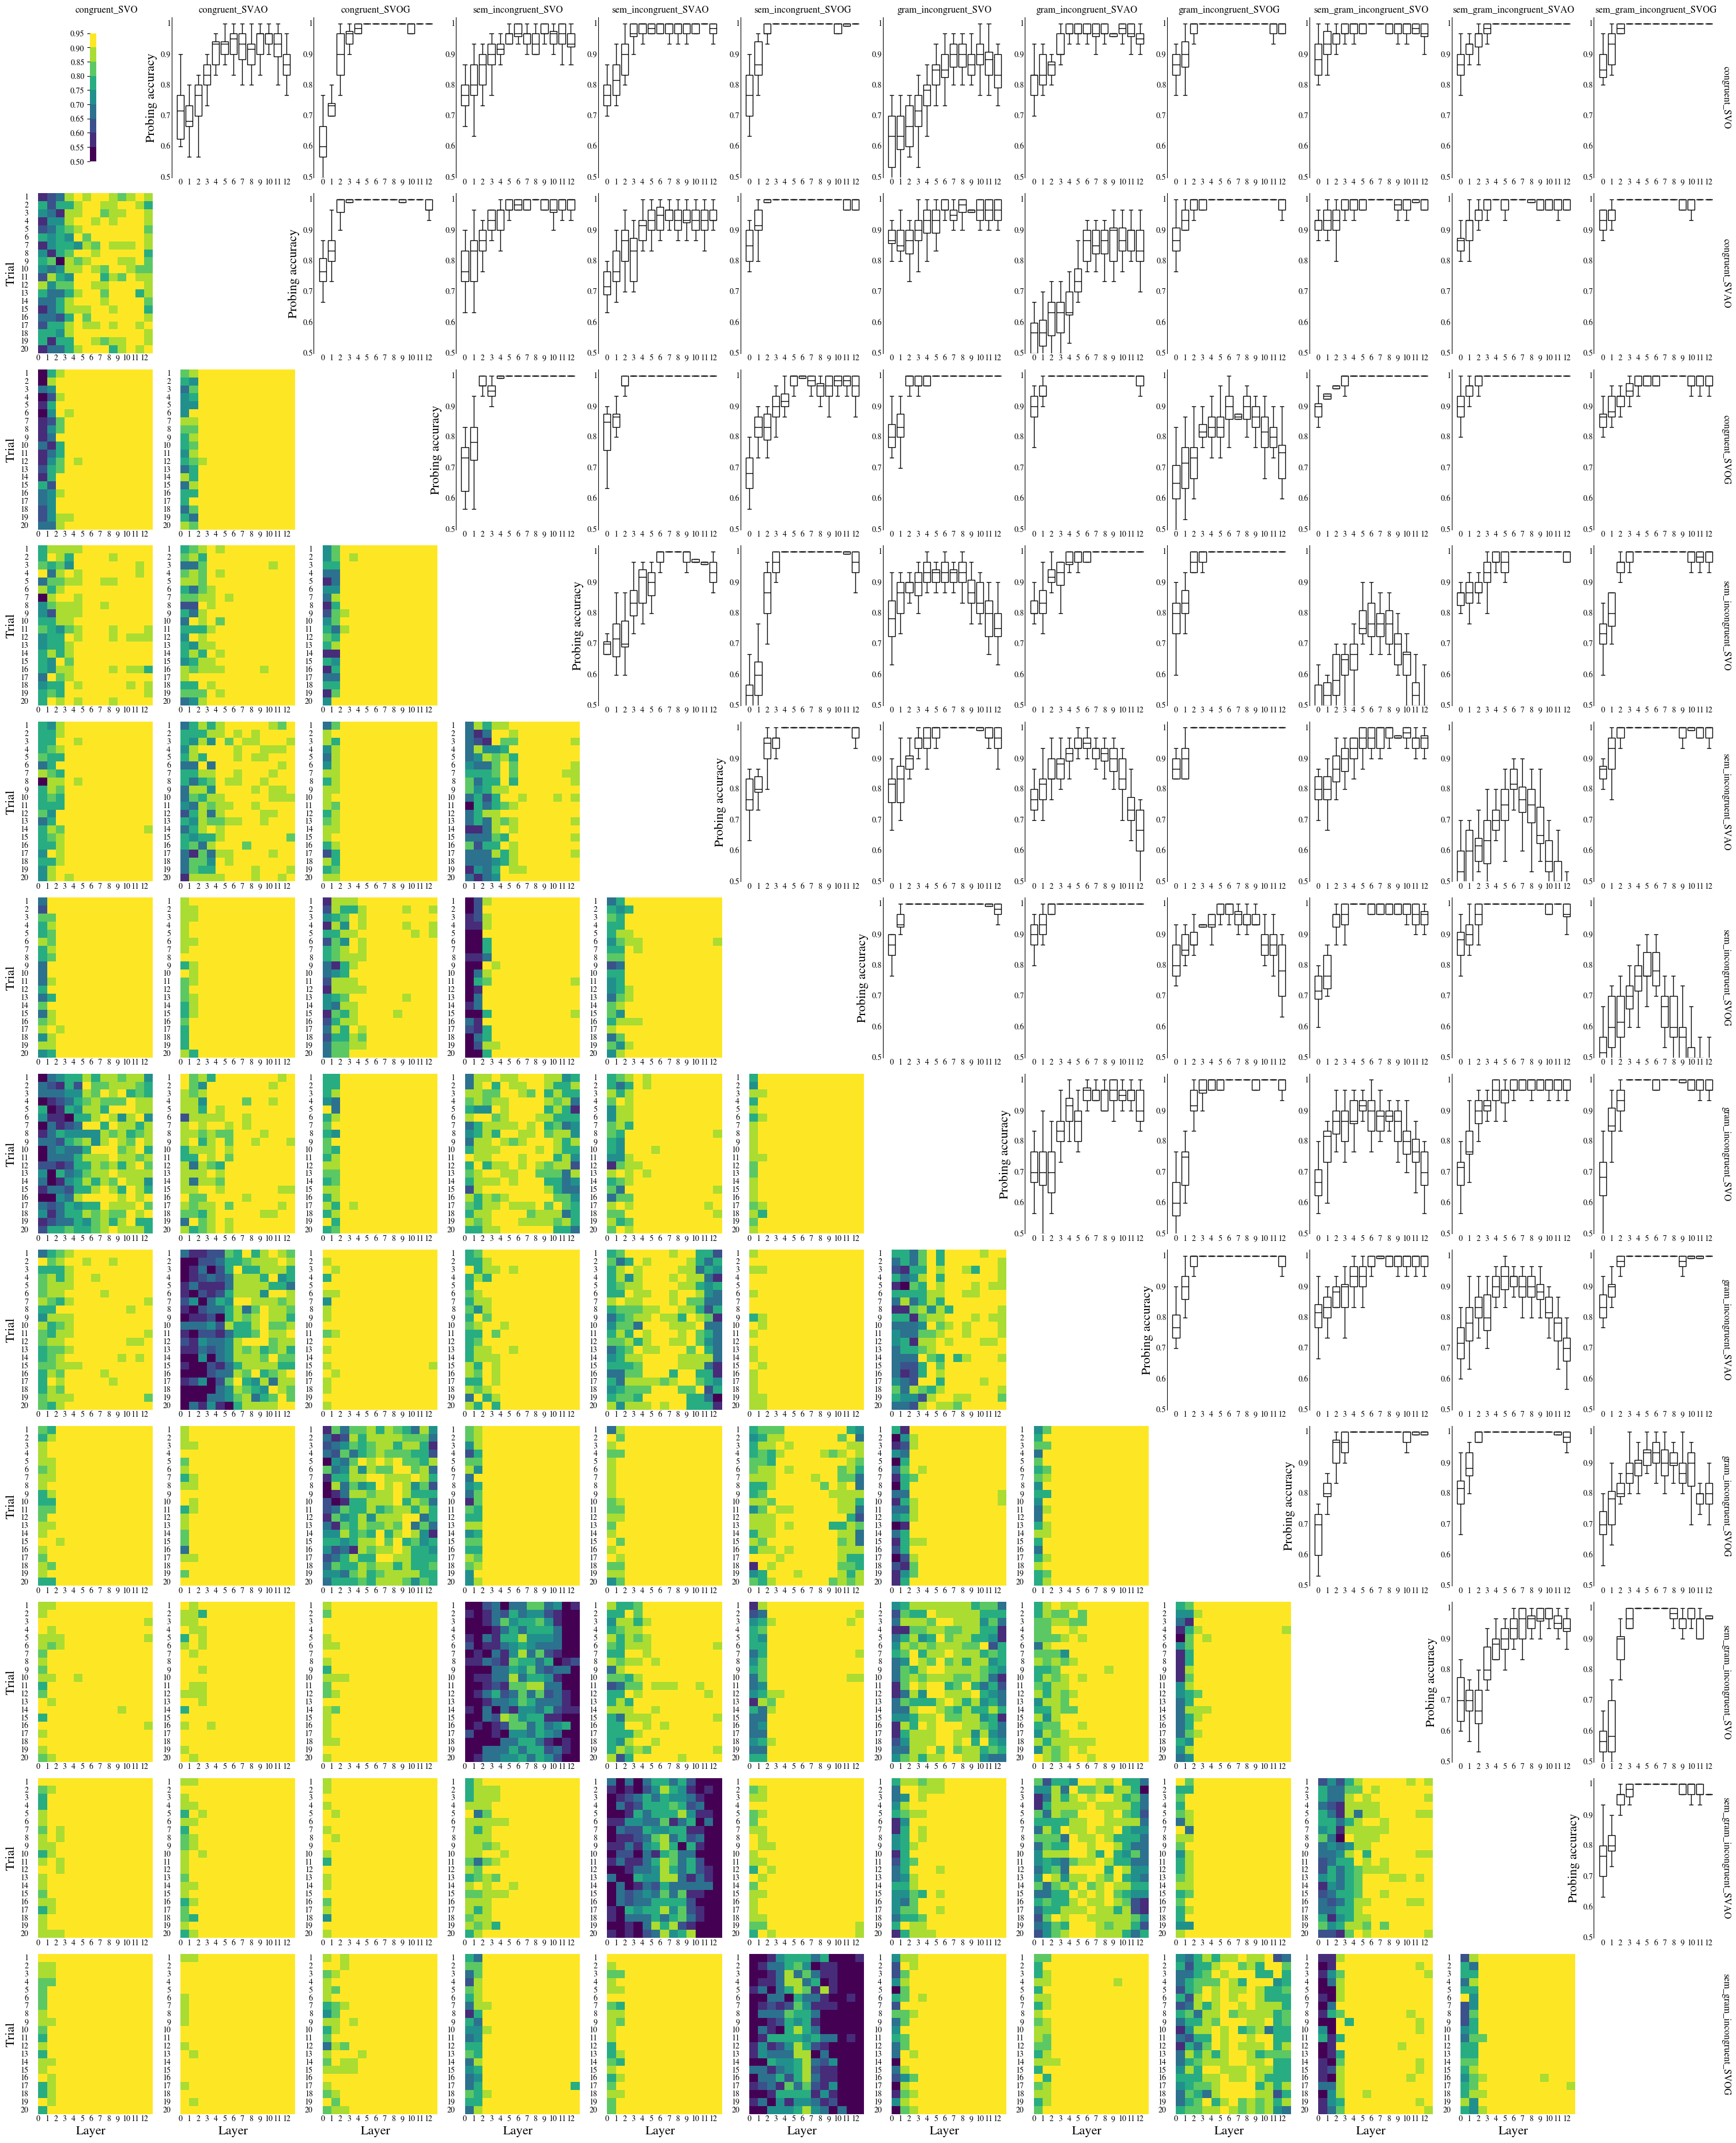

In [16]:
g = plot_zmatrix(df, './res.pdf')

In [34]:
data_layer

title_r,congruent_SVO,congruent_SVAO,congruent_SVOG,sem_incongruent_SVO,sem_incongruent_SVAO,sem_incongruent_SVOG,gram_incongruent_SVO,gram_incongruent_SVAO,gram_incongruent_SVOG,sem_gram_incongruent_SVO,sem_gram_incongruent_SVAO,sem_gram_incongruent_SVOG
title_l,,,,,,,,,,,,
congruent_SVO,NaN,0.868333,0.995000,0.936667,0.976667,0.995000,0.833333,0.948333,0.990000,0.965000,0.998333,0.998333
congruent_SVAO,0.868333,NaN,0.975000,0.986667,0.940000,0.990000,0.963333,0.846667,0.986667,0.988333,0.988333,0.998333
congruent_SVOG,0.995000,0.975000,NaN,0.996667,1.000000,0.955000,0.991667,0.983333,0.731667,0.998333,0.998333,0.970000
sem_incongruent_SVO,0.936667,0.986667,0.996667,NaN,0.935000,0.958333,0.755000,0.993333,0.998333,0.455000,0.988333,0.971667
sem_incongruent_SVAO,0.976667,0.940000,1.000000,0.935000,NaN,0.981667,0.958333,0.665000,0.998333,0.951667,0.406667,0.983333
sem_incongruent_SVOG,0.995000,0.990000,0.955000,0.958333,0.981667,NaN,0.980000,0.993333,0.778333,0.958333,0.970000,0.400000
gram_incongruent_SVO,0.833333,0.963333,0.991667,0.755000,0.958333,0.980000,NaN,0.916667,0.980000,0.698333,0.975000,0.975000
gram_incongruent_SVAO,0.948333,0.846667,0.983333,0.993333,0.665000,0.993333,0.916667,NaN,0.988333,0.983333,0.683333,0.993333
gram_incongruent_SVOG,0.990000,0.986667,0.731667,0.998333,0.998333,0.778333,0.980000,0.988333,NaN,0.986667,0.980000,0.798333


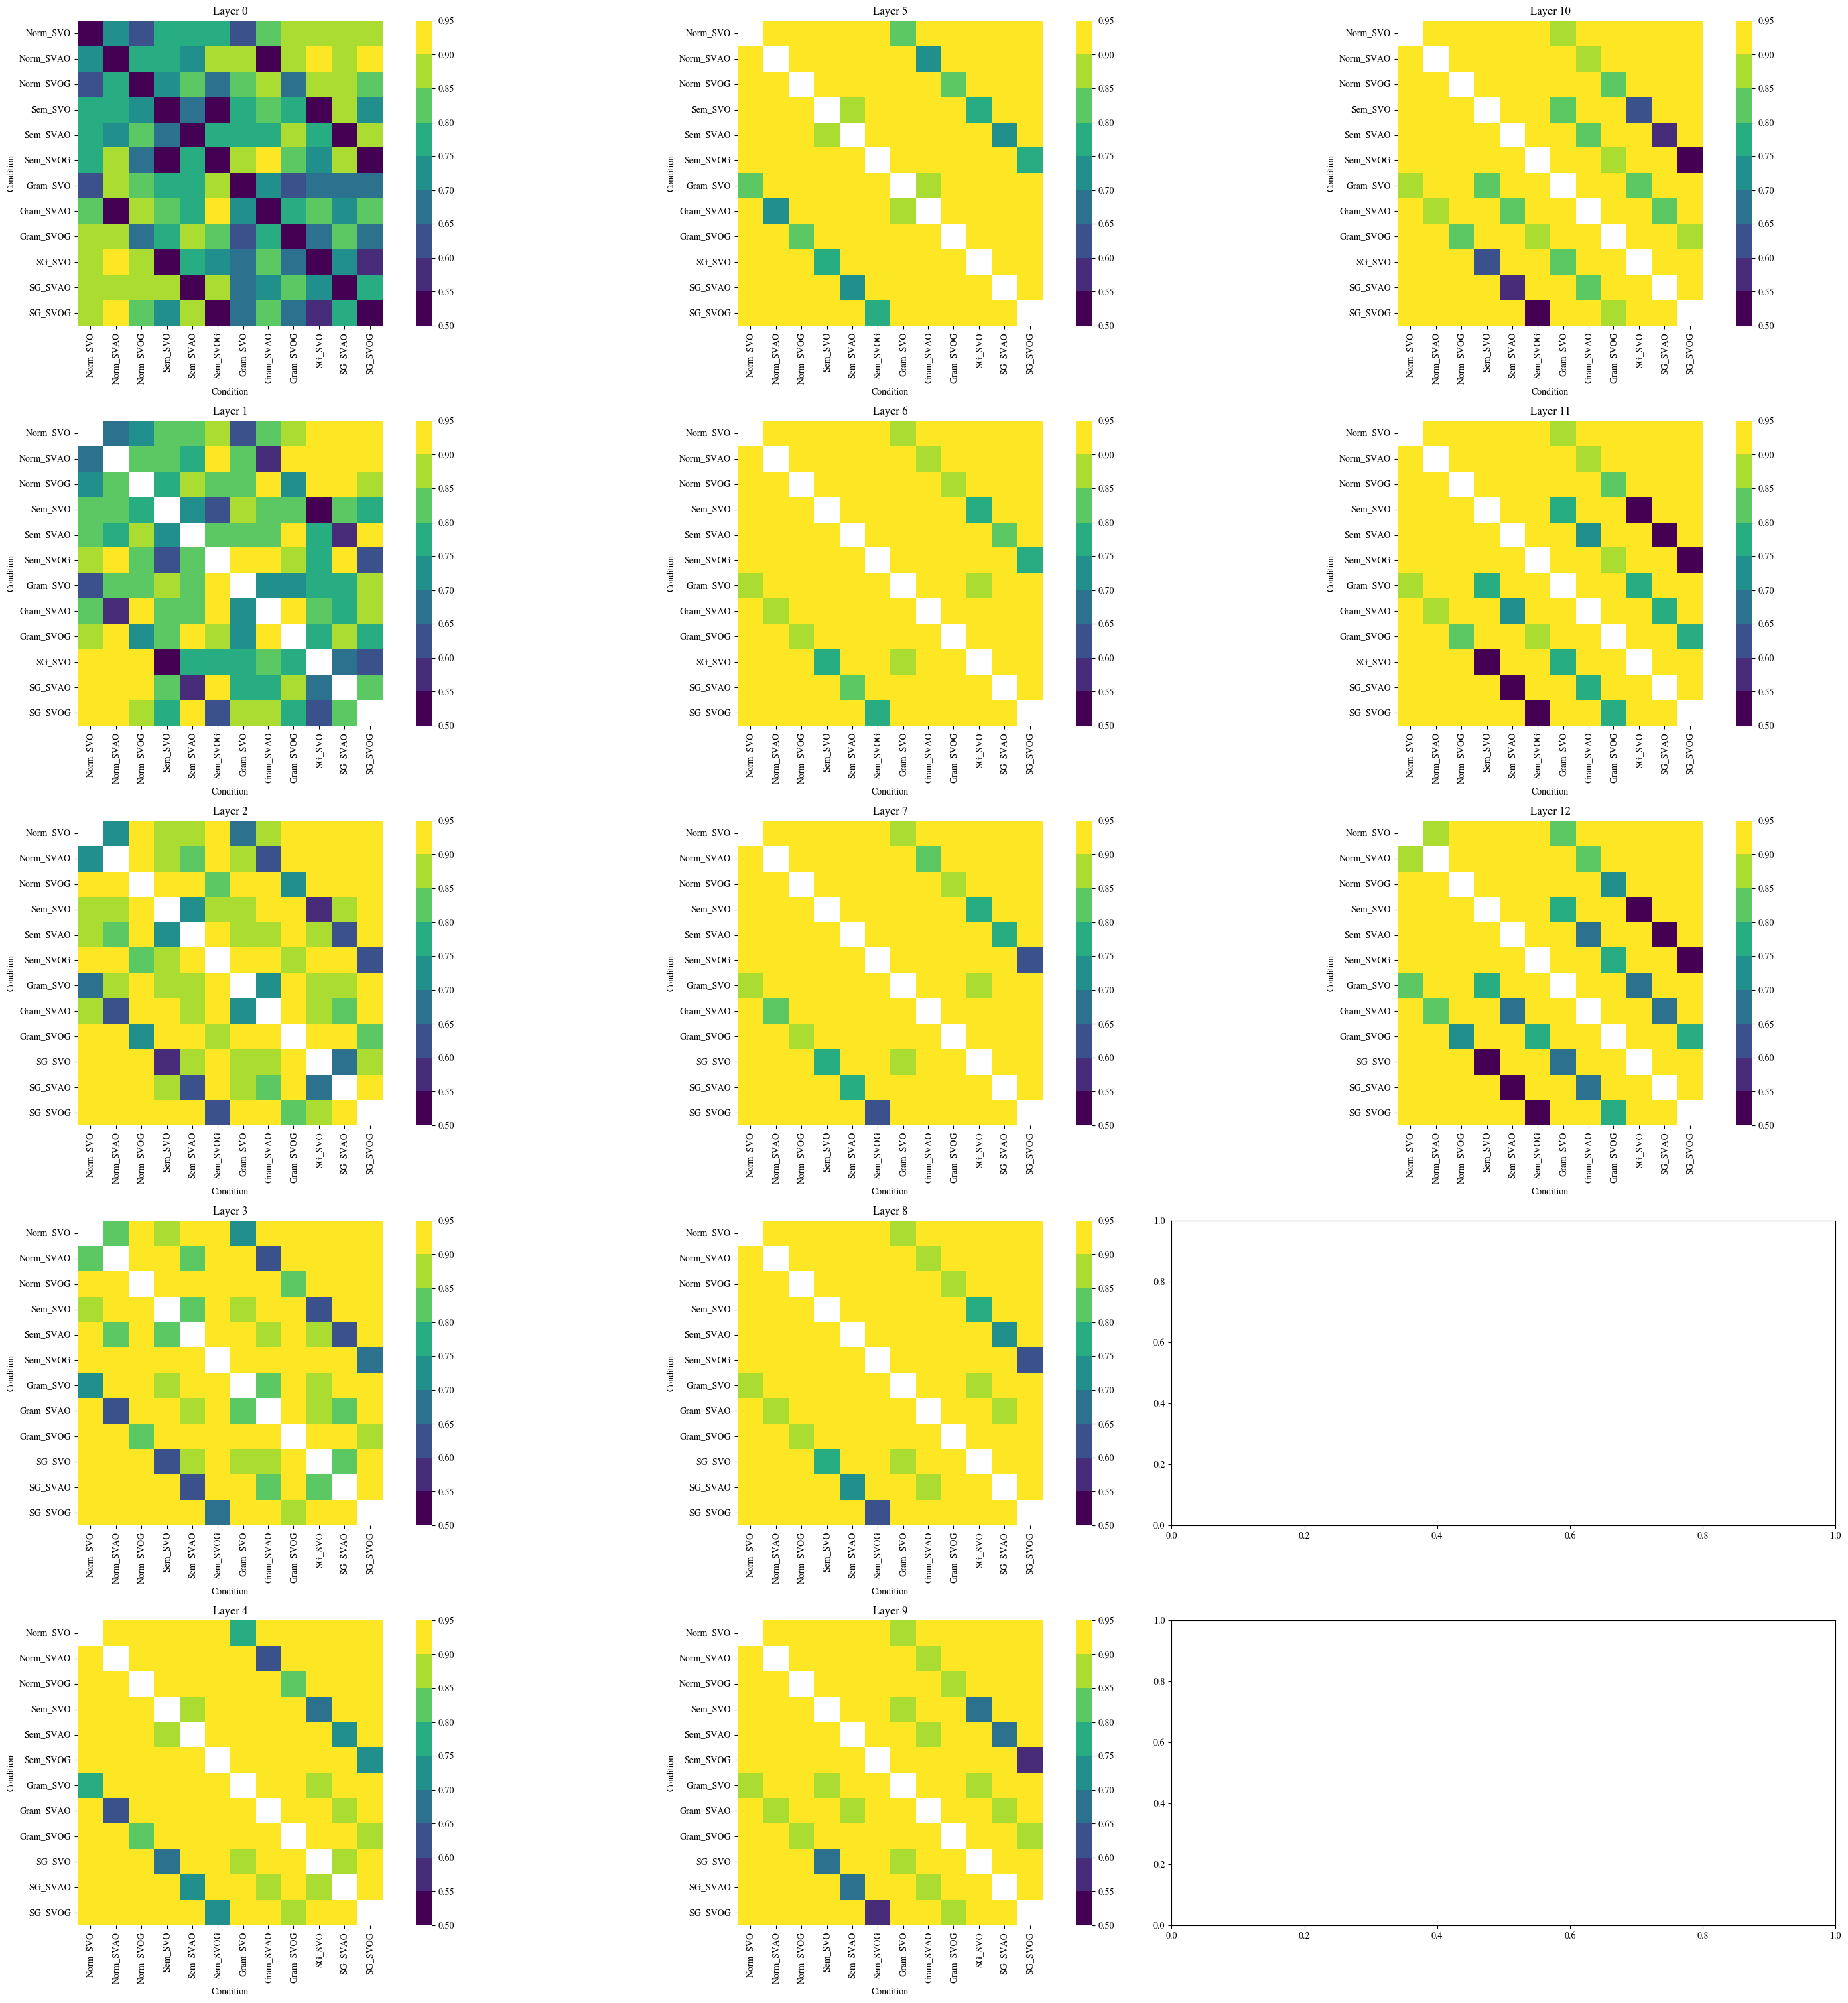

In [36]:
names_dict = {'congruent_SVAO': 'Norm_SVAO', 'congruent_SVO': 'Norm_SVO', 'congruent_SVOG': 'Norm_SVOG',
       'gram_incongruent_SVAO': 'Gram_SVAO', 'gram_incongruent_SVO': 'Gram_SVO',
       'gram_incongruent_SVOG': 'Gram_SVOG', 'sem_gram_incongruent_SVAO': 'SG_SVAO',
       'sem_gram_incongruent_SVO': 'SG_SVO', 'sem_gram_incongruent_SVOG': 'SG_SVOG',
       'sem_incongruent_SVAO': 'Sem_SVAO', 'sem_incongruent_SVO': 'Sem_SVO',
       'sem_incongruent_SVOG': 'Sem_SVOG'}

order_conds = ['congruent_SVO', 'congruent_SVAO', 'congruent_SVOG',
                'sem_incongruent_SVO', 'sem_incongruent_SVAO', 'sem_incongruent_SVOG',
                'gram_incongruent_SVO', 'gram_incongruent_SVAO', 'gram_incongruent_SVOG',
               'sem_gram_incongruent_SVO', 'sem_gram_incongruent_SVAO', 'sem_gram_incongruent_SVOG']

order_conds2 = ['Norm_SVO', 'Norm_SVAO', 'Norm_SVOG',
                'Sem_SVO', 'Sem_SVAO', 'Sem_SVOG',
                'Gram_SVO', 'Gram_SVAO', 'Gram_SVOG',
               'SG_SVO', 'SG_SVAO', 'SG_SVOG']

df_mean = df.groupby(['title_l', 'title_r', 'layer_num']).mean('results').reset_index()[['title_l', 'title_r', 'layer_num', 'results']]
df_mean.to_excel('mean_layer_scores.xlsx', index=False)

RDM_NN = {}

fig, axes = plt.subplots(5, 3, figsize=(30, 30
                                    ))
bounds = np.arange(0.5, 1, 0.05)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# df.to_excel('res_rdm.xlsx', index=False)
with pd.ExcelWriter('mean_layer_scores.xlsx') as writer:
    df[['title_l', 'title_r', 'layer_num', 'trial_num', 'results']].to_excel(writer, sheet_name = 'all_scores', index=False)
    for layer_num, layer_df in df_mean.groupby('layer_num'):
        layer_df['title_l'] = layer_df['title_l'].map(names_dict)
        layer_df['title_r'] = layer_df['title_r'].map(names_dict)
        data_layer = layer_df.drop_duplicates(['title_l', 'title_r']).pivot(index='title_l', columns='title_r', values='results')
        data_layer = data_layer[order_conds2].loc[order_conds2]
        
        data_layer.to_excel(writer, sheet_name = f'Layer {layer_num}')
        RDM_NN[f'layer_{layer_num}'] = np.array(data_layer.values)
        sns.heatmap(data_layer, norm=norm, linewidths=0.0, rasterized=True,
                                 square = True, ax=axes[layer_num % 5, layer_num // 5],
                                 cbar=True, cmap="viridis",)
        axes[layer_num % 5, layer_num // 5].set_title(f'Layer {layer_num}')
        axes[layer_num % 5, layer_num // 5].set_ylabel('Condition')
        axes[layer_num % 5, layer_num // 5].set_xlabel('Condition')

fig.tight_layout() 
fig.savefig('layer_rdm.pdf')

from scipy.io import savemat
savemat('RDM_NN.mat', RDM_NN)

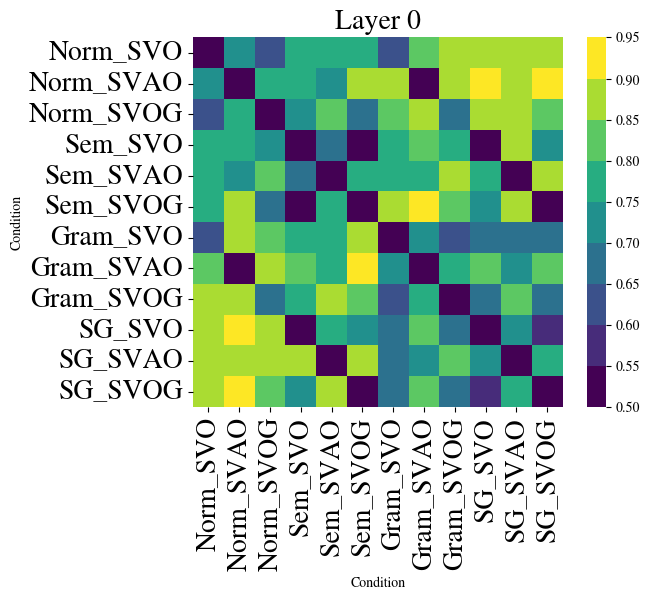

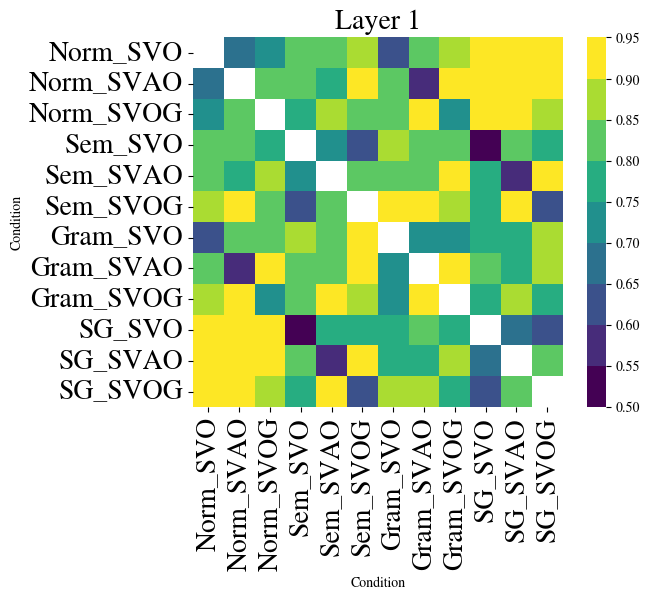

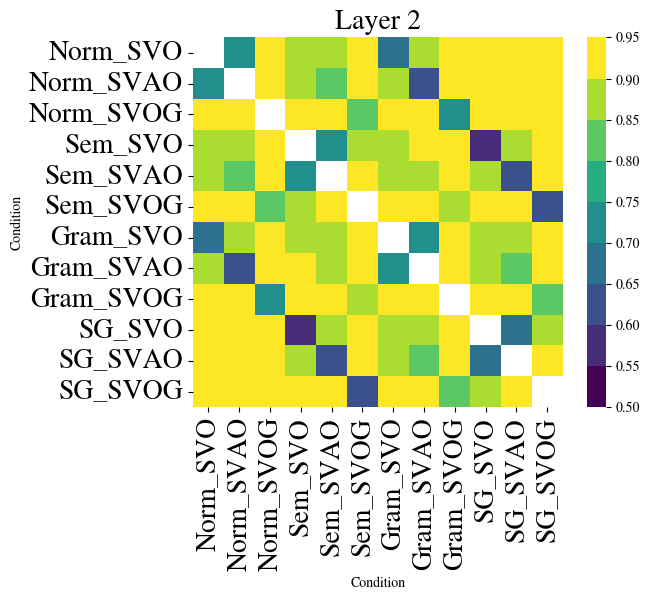

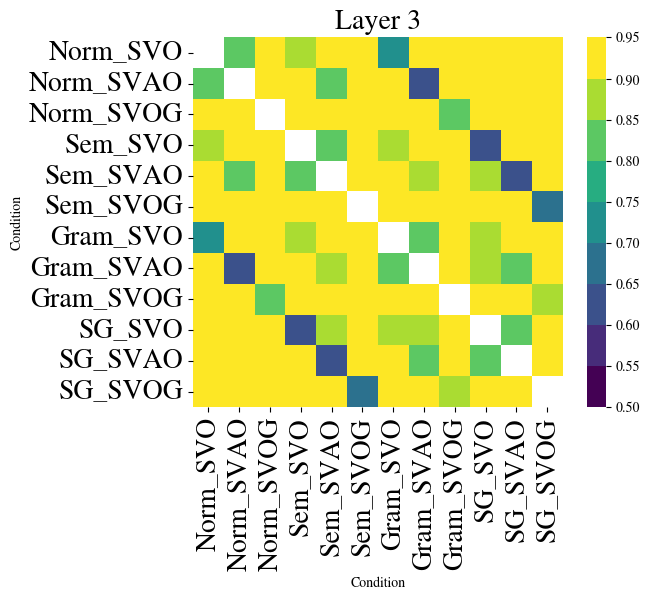

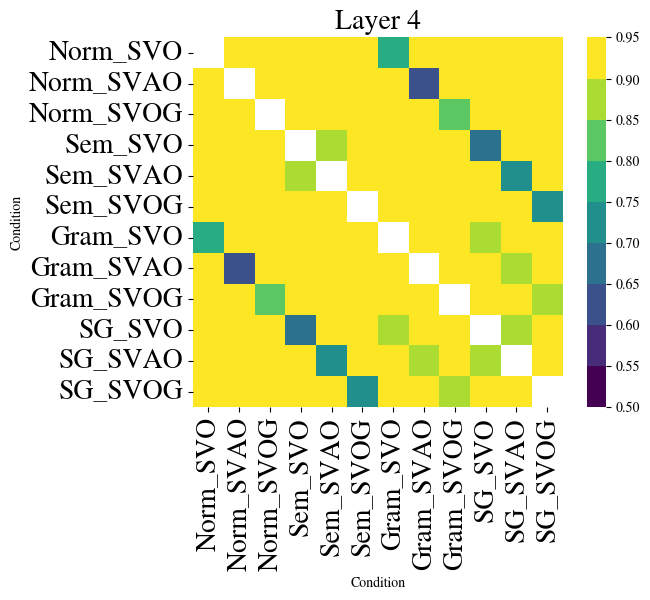

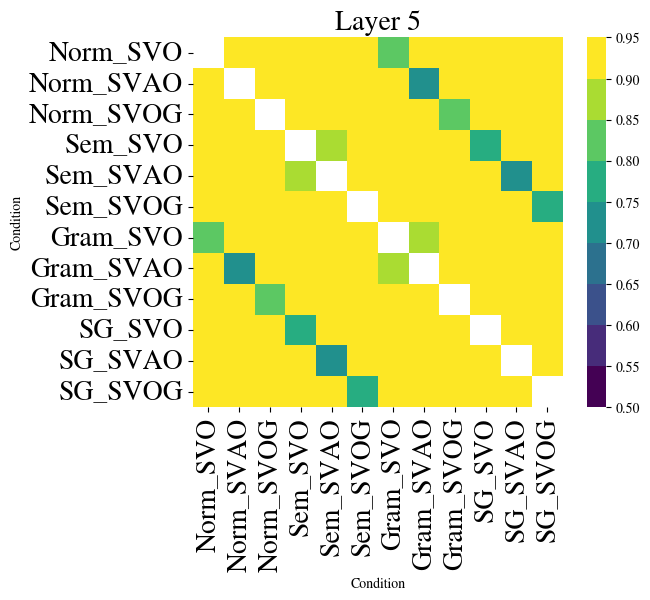

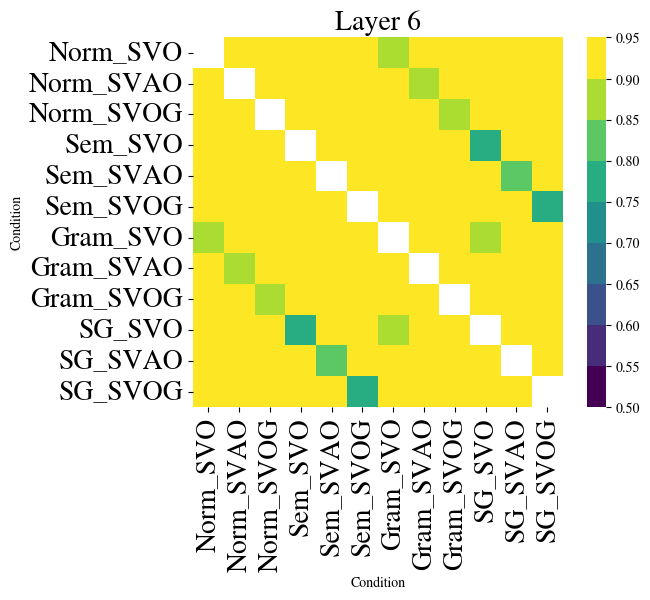

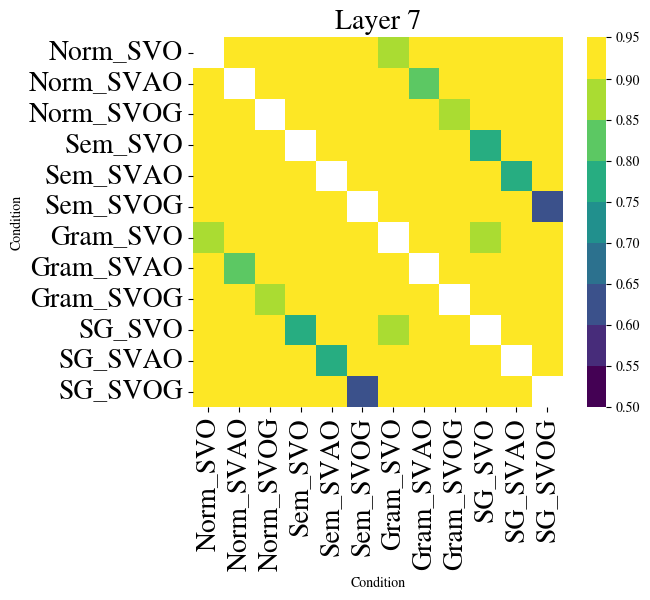

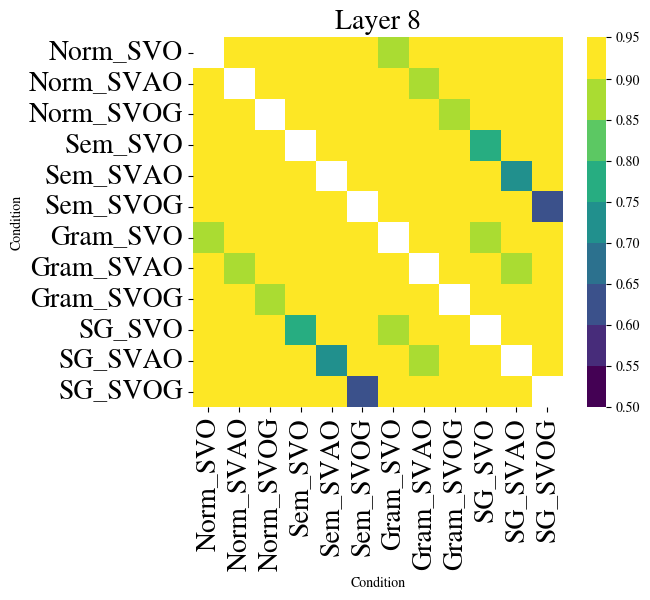

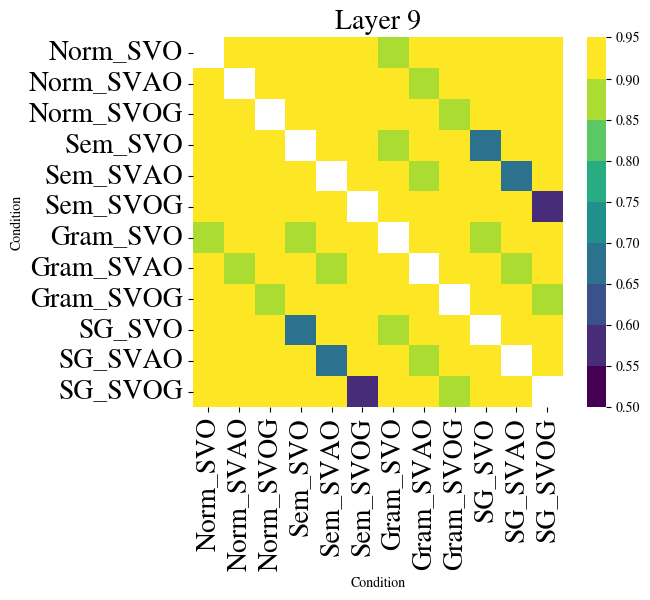

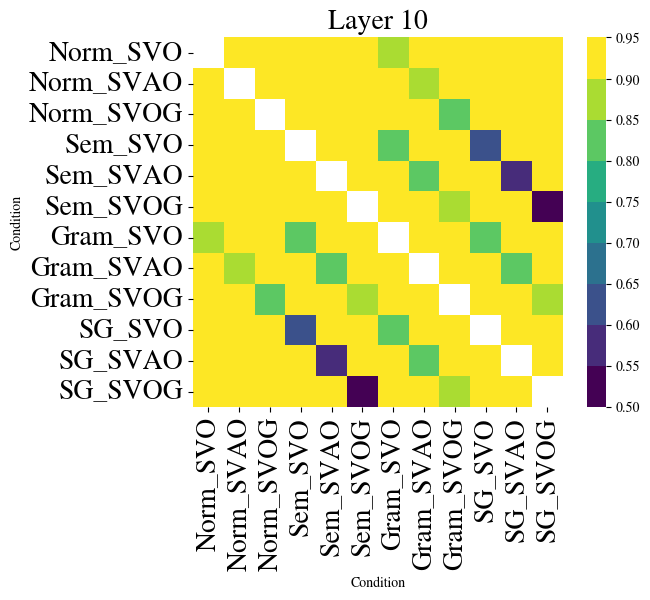

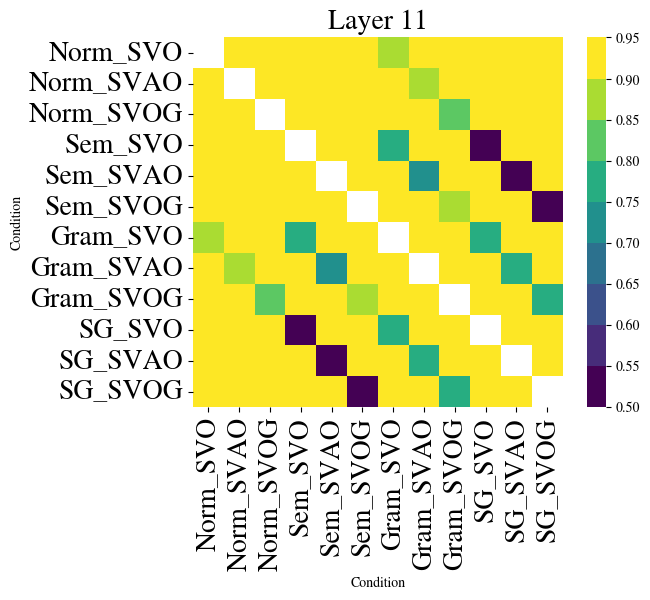

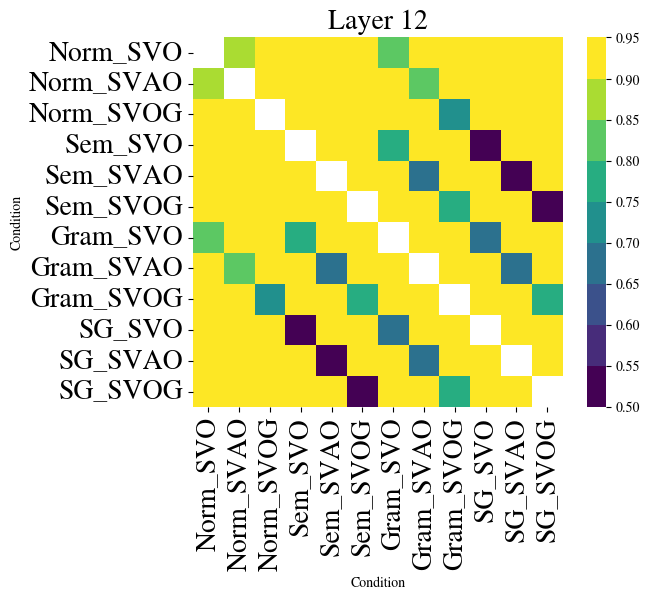

In [43]:
with pd.ExcelWriter('mean_layer_scores.xlsx') as writer:
    df[['title_l', 'title_r', 'layer_num', 'trial_num', 'results']].to_excel(writer, sheet_name = 'all_scores', index=False)
    for layer_num, layer_df in df_mean.groupby('layer_num'):
        layer_df['title_l'] = layer_df['title_l'].map(names_dict)
        layer_df['title_r'] = layer_df['title_r'].map(names_dict)
        data_layer = layer_df.drop_duplicates(['title_l', 'title_r']).pivot(index='title_l', columns='title_r', values='results')
        data_layer = data_layer[order_conds2].loc[order_conds2]
        
        data_layer.to_excel(writer, sheet_name = f'Layer {layer_num}')
        RDM_NN[f'layer_{layer_num}'] = np.array(data_layer.values)
        f, ax = plt.subplots()
        sns.heatmap(data_layer, norm=norm, linewidths=0.0, rasterized=True,
                                 square = True, axes=ax,
                                 cbar=True, cmap="viridis",)

        ax.set_title(f'Layer {layer_num}', fontsize=20)
        ax.set_ylabel('Condition')
        ax.set_xlabel('Condition')
        ax.set_xticklabels(labels = order_conds2, fontsize=20)
        ax.set_yticklabels(labels = order_conds2,fontsize=20)
        f.savefig(f'RDMs/layer_{layer_num}_RDM.pdf', bbox_inches='tight')

In [47]:
import pickle
with open('data_NN.pickle', 'wb') as f:
  pickle.dump(results, f)

In [48]:
results.keys()

dict_keys(['12x12/gram_incongruent_SVO_VS_gram_incongruent_SVOG_df', '12x12/sem_incongruent_SVOG_VS_sem_gram_incongruent_SVAO_df', '12x12/gram_incongruent_SVOG_VS_sem_gram_incongruent_SVOG_df', '12x12/gram_incongruent_SVAO_VS_sem_gram_incongruent_SVOG_df', '12x12/congruent_SVAO_VS_sem_gram_incongruent_SVAO_df', '12x12/congruent_SVO_VS_congruent_SVOG_df', '12x12/gram_incongruent_SVO_VS_sem_gram_incongruent_SVO_df', '12x12/congruent_SVOG_VS_gram_incongruent_SVAO_df', '12x12/gram_incongruent_SVO_VS_sem_incongruent_SVAO_df', '12x12/gram_incongruent_SVAO_VS_gram_incongruent_SVO_df', '12x12/congruent_SVOG_VS_sem_incongruent_SVAO_df', '12x12/congruent_SVAO_VS_sem_gram_incongruent_SVOG_df', '12x12/gram_incongruent_SVOG_VS_sem_incongruent_SVOG_df', '12x12/gram_incongruent_SVOG_VS_sem_gram_incongruent_SVO_df', '12x12/congruent_SVOG_VS_sem_gram_incongruent_SVO_df', '12x12/gram_incongruent_SVAO_VS_sem_gram_incongruent_SVO_df', '12x12/sem_incongruent_SVO_VS_sem_gram_incongruent_SVOG_df', '12x12/con

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle
results2 = {}
for experiment in experiments:
    fname = experiment.split('.')[0]
    res = pickle.load(open(f"/content/drive/MyDrive/{fname}_exp.pickle", 'rb'))
    results2[fname] = res

In [ ]:
data_rows = []
for title, res in results2.items():
    for layer_num, layer_results in enumerate(res[0]):
        for trial_num, trial_results in enumerate(layer_results):
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_l": title.split('_')[0],
                "title_r": title.split('_')[1],
                "results": trial_results
            })
            data_rows.append({
                "layer_num": layer_num,
                "trial_num": trial_num,
                "title_r": title.split('_')[0],
                "title_l": title.split('_')[1],
                "results": trial_results
            })
data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
                  "title_l": 'gram', "title_r": 'gram'})

data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
                  "title_l": 'sem', "title_r": 'sem'})

data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
                  "title_l": 'semgram', "title_r": 'semgram'})

data_rows.append({"layer_num": 0, "trial_num": 0, "results": 0.,
                  "title_l": 'norm', "title_r": 'norm'})
df2 = pd.DataFrame(data_rows)
df2

In [ ]:
df2 = df2.sort_values(by=['title_l', 'title_r'])

renamer_di = {
    "gram": "Gram Incongruent",
    "sem": "Sem Incongruent",
    "semgram": "S&G Incongruent",
    "norm": "Normal"
}

df2['title_l'] = df2['title_l'].apply(lambda s: renamer_di.get(s, s))
df2['title_r'] = df2['title_r'].apply(lambda s: renamer_di.get(s, s))

In [ ]:
g = plot_zmatrix(df2, './res.pdf')

### Tokenization


In [ ]:
def tokenize_word(row, column):
    position = row['position']
    tokenized = tokenizer.tokenize(row[c].split()[int(position)])
    return tokenized

for c in mozgi_data.columns:
    if 'cong' in c and 'tokenized' not in c:
        mozgi_data[f"{c}_tokenized"] = mozgi_data.apply(tokenize_word, args=(c,), axis=1)

In [ ]:

for c in mozgi_data.columns:
    if 'tokenized' in c:
        mozgi_data[c.replace('tokenized', "toklen")] = mozgi_data[c].apply(len)

In [ ]:
mozgi_data['congruent_toklen'].value_counts()

In [ ]:
mozgi_data[[c for c in mozgi_data.columns if 'toklen' in c]].value_counts()

In [ ]:


In 85 cases all the tokenizations were of length 1
In 17 cases semgram introduced tokenization becoming 2
In 13 cased gram introduced tokenization becoming 2
In 11 cases sem introduced tokenization becoming 2 (semgram subsequently too)
In 5  cases all the incongruent tokenizations were of length 2 while congruent was of length 1
